# 2D U-Net Sanity Test (2)

Code from https://github.com/milesial/Pytorch-UNet

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch
from torch import nn
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader

from segmentation_dataset_2D import SegmentationDataset2D, load_sanity_dataset

### Load Sanity Dataset Object

Loading 2D sanity dataset...
MRI shape torch.Size([3, 256, 256])
Mask shape torch.Size([1, 256, 256])


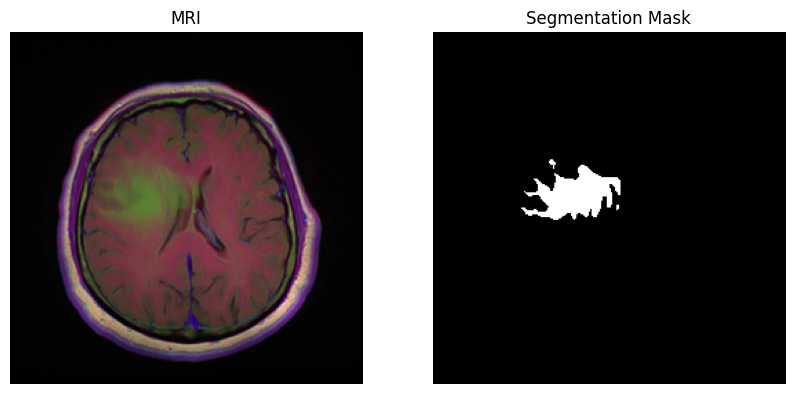

In [2]:
sanity_data = load_sanity_dataset()

X = sanity_data[0][0]
Y = sanity_data[0][1]
print('MRI shape', X.shape)
print('Mask shape',Y.shape)

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(F.to_pil_image(X))
plt.title('MRI')
plt.axis('off')

plt.subplot(122)
plt.imshow(F.to_pil_image(Y), cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.show()

### U-Net model

In [3]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = torch.sigmoid(x) # JUSA ADDED SIGMOID TO TURN RESULT INTO PROBABILITIES
        return x

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

### Sanity Test

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

torch.Size([3, 256, 256])
torch.Size([256, 256])
tensor(0.0257, grad_fn=<MinBackward1>) tensor(0.9586, grad_fn=<MaxBackward1>)


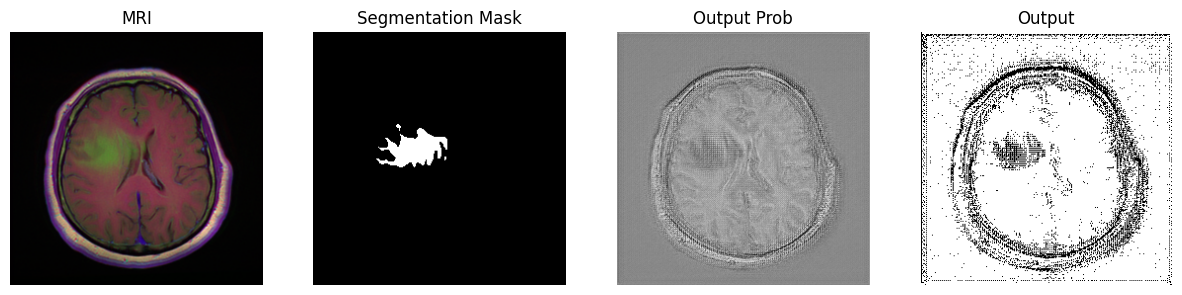

In [5]:
net = UNet().to(device)

y_prob = net(X.unsqueeze(0)).to('cpu').squeeze()

print(X.shape)
print(y_prob.shape)
print(y_prob.min(), y_prob.max())

plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(F.to_pil_image(X))
plt.title('MRI')
plt.axis('off')

plt.subplot(142)
plt.imshow(F.to_pil_image(Y), cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.subplot(143)
plt.imshow(F.to_pil_image(y_prob), cmap='gray')
plt.title('Output Prob')
plt.axis('off')

plt.subplot(144)
plt.imshow(F.to_pil_image(torch.round(y_prob)), cmap='gray')
plt.title('Output')
plt.axis('off')


plt.show()


In [6]:
def get_optimizer(net):
    return torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9)

def train(data_loader, net, optimizer, weight=(0.9, 0.1)):
    for data in data_loader:

        inputs, targets = data[0].to(device), data[1].to(device)
        outputs = net(inputs)

        loss = nn.BCELoss()(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del inputs
        del targets

        return loss.item()

Epoch: 0 Loss: 0.7921273708343506
Epoch: 1 Loss: 0.630630612373352
Epoch: 2 Loss: 0.4442371129989624
Epoch: 3 Loss: 0.28531742095947266
Epoch: 4 Loss: 0.1758885681629181
Epoch: 5 Loss: 0.11823473870754242
Epoch: 6 Loss: 0.08874861896038055
Epoch: 7 Loss: 0.07484474778175354
Epoch: 8 Loss: 0.06659039855003357
Epoch: 9 Loss: 0.05627022683620453
Epoch: 10 Loss: 0.046546969562768936
Epoch: 11 Loss: 0.03937218338251114
Epoch: 12 Loss: 0.034687384963035583
Epoch: 13 Loss: 0.031162474304437637
Epoch: 14 Loss: 0.028278112411499023
Epoch: 15 Loss: 0.025809260085225105
Epoch: 16 Loss: 0.023689545691013336
Epoch: 17 Loss: 0.021916335448622704
Epoch: 18 Loss: 0.020499832928180695
Epoch: 19 Loss: 0.019408201798796654
Epoch: 20 Loss: 0.018538236618041992
Epoch: 21 Loss: 0.017827201634645462
Epoch: 22 Loss: 0.017259500920772552
Epoch: 23 Loss: 0.016741158440709114
Epoch: 24 Loss: 0.016249090433120728
Epoch: 25 Loss: 0.01579965092241764
Epoch: 26 Loss: 0.015356802381575108
Epoch: 27 Loss: 0.0149008482

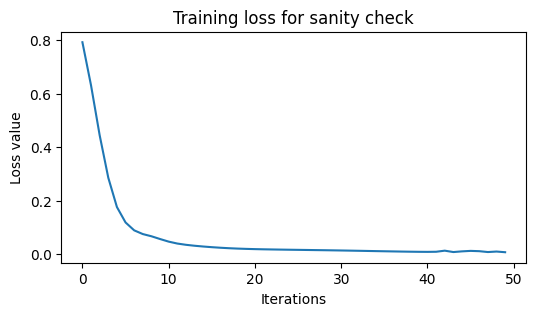

In [7]:
net.train()
optimizer = get_optimizer(net)
loss_graph = []

EPOCH = 50

sanity_loader = DataLoader(sanity_data, batch_size=1, num_workers=0, shuffle=False)
for e in range(EPOCH):
    loss = train(sanity_loader, net, optimizer)
    loss_graph.append(loss)
    print("Epoch: {} Loss: {}".format(e, loss))

plt.figure(figsize=(6, 3))
plt.plot(np.arange(0, EPOCH), loss_graph)
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.title('Training loss for sanity check')
plt.show()

torch.Size([3, 256, 256])
torch.Size([256, 256])
tensor(7.7865e-08, grad_fn=<MinBackward1>) tensor(0.9998, grad_fn=<MaxBackward1>)


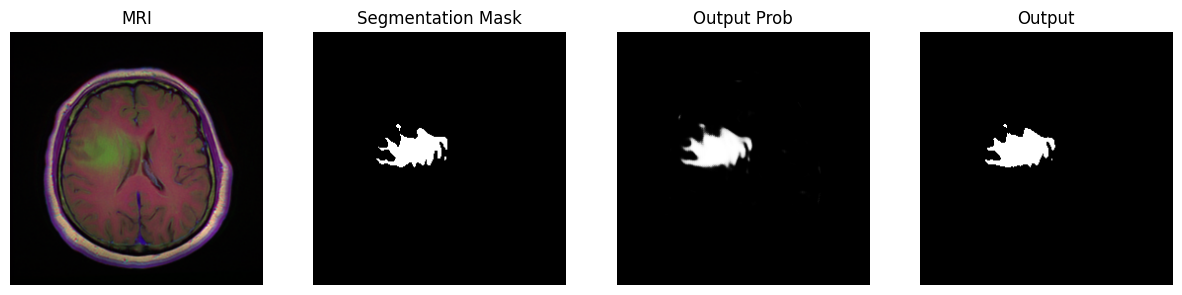

In [8]:
y_prob = net(X.unsqueeze(0)).to('cpu').squeeze()

print(X.shape)
print(y_prob.shape)
print(y_prob.min(), y_prob.max())

plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(F.to_pil_image(X))
plt.title('MRI')
plt.axis('off')

plt.subplot(142)
plt.imshow(F.to_pil_image(Y), cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.subplot(143)
plt.imshow(F.to_pil_image(y_prob), cmap='gray')
plt.title('Output Prob')
plt.axis('off')

plt.subplot(144)
plt.imshow(F.to_pil_image(torch.round(y_prob)), cmap='gray')
plt.title('Output')
plt.axis('off')

plt.show()